# 02 — Logistic Regression (TF-IDF & Word2Vec)

This notebook trains two logistic regression classifiers for fake news detection:

1. **TF-IDF** — sparse bag-of-words / bigram features  
2. **Word2Vec** — dense semantic embeddings (Google News, 300d)  

Both models are evaluated with standard metrics, cross-validation, and SHAP explainability. Trained artifacts are saved to `models/`.

**Outline**
1. Load data  
2. Train/test split  
3. TF-IDF Logistic Regression — metrics, SHAP, save  
4. Word2Vec Logistic Regression — metrics, save  
5. 5-fold cross-validation (both models)  
6. Error analysis (TF-IDF model)  

In [1]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from collections import Counter

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

import shap

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

print('Libraries loaded.')

Libraries loaded.


---
## 1. Load Data

In [2]:
df = pd.read_csv('../data/processed/cleaned_isot.csv')
print(f'Loaded {len(df):,} rows')
print(df['class'].value_counts())
df.head(3)

Loaded 44,889 rows
class
0    23472
1    21417
Name: count, dtype: int64


,clean_text,title_text,class
0,budget fight loom republican flip fiscal scrip...,"As U.S. budget fight looms, Republicans flip t...",1
1,militari accept transgend recruit monday penta...,U.S. military to accept transgender recruits o...,1
2,senior republican senat let mueller jobth spec...,Senior U.S. Republican senator: 'Let Mr. Muell...,1


---
## 2. Train / Test Split (80/20, stratified)

In [3]:
X = df['clean_text'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train size : {len(X_train):,}')
print(f'Test size  : {len(X_test):,}')

Train size : 35,911
Test size  : 8,978


---
## 3. TF-IDF Logistic Regression

We use `TfidfVectorizer` with up to 50,000 unigram + bigram features. The vectorizer is **fit only on the training set** to prevent data leakage, then used to transform the test set.

`LogisticRegression` with `max_iter=1000` is then trained on the resulting sparse matrix.

In [4]:
# Fit vectorizer
tfidf = TfidfVectorizer(max_features=50_000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

# Train model
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf.fit(X_train_tfidf, y_train)

y_pred_tfidf = lr_tfidf.predict(X_test_tfidf)
y_prob_tfidf = lr_tfidf.predict_proba(X_test_tfidf)[:, 1]

print('TF-IDF Logistic Regression Results')
print(f"  Accuracy  : {accuracy_score(y_test, y_pred_tfidf):.4f}")
print(f"  Precision : {precision_score(y_test, y_pred_tfidf):.4f}")
print(f"  Recall    : {recall_score(y_test, y_pred_tfidf):.4f}")
print(f"  F1        : {f1_score(y_test, y_pred_tfidf):.4f}")

TF-IDF Logistic Regression Results
  Accuracy  : 0.9812
  Precision : 0.9757
  Recall    : 0.9851
  F1        : 0.9804


### 3a. Confusion Matrix

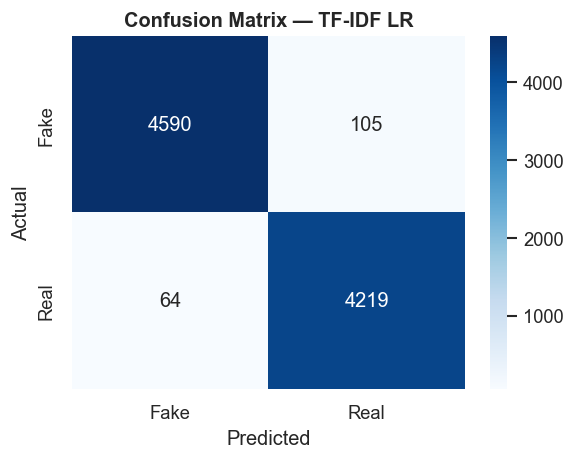

In [5]:
cm = confusion_matrix(y_test, y_pred_tfidf)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix — TF-IDF LR', fontweight='bold')
plt.tight_layout(); plt.show()

### 3b. ROC Curve & Precision-Recall Curve

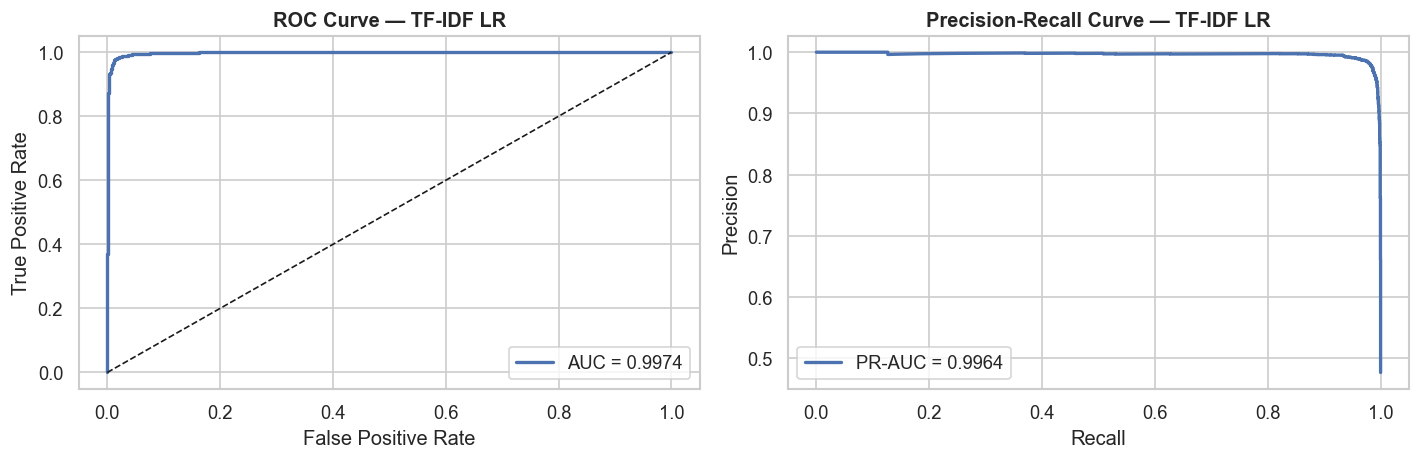

In [6]:
fpr, tpr, _ = roc_curve(y_test, y_prob_tfidf)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_test, y_prob_tfidf)
pr_auc = auc(rec, prec)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_xlabel('False Positive Rate'); ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve — TF-IDF LR', fontweight='bold')
ax1.legend()

ax2.plot(rec, prec, lw=2, label=f'PR-AUC = {pr_auc:.4f}')
ax2.set_xlabel('Recall'); ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve — TF-IDF LR', fontweight='bold')
ax2.legend()

plt.tight_layout(); plt.show()

### 3c. SHAP Explainability

SHAP (SHapley Additive exPlanations) decomposes each prediction into the contributions of individual features. With a linear model we use `shap.LinearExplainer` which is exact and fast.

The **summary bar plot** shows globally which words most influence fake vs. real predictions. The **waterfall plots** show individual article decisions, making model reasoning transparent.

In [7]:
# Build the SHAP explainer
explainer = shap.LinearExplainer(lr_tfidf, X_train_tfidf, feature_perturbation='interventional')

# Compute SHAP values for the test set (use a sample for speed)
sample_idx = np.random.RandomState(42).choice(X_test_tfidf.shape[0], size=2000, replace=False)
X_sample = X_test_tfidf[sample_idx]
shap_values = explainer.shap_values(X_sample)

feature_names = tfidf.get_feature_names_out()
print(f'SHAP values computed for {X_sample.shape[0]} samples.')

SHAP values computed for 2000 samples.


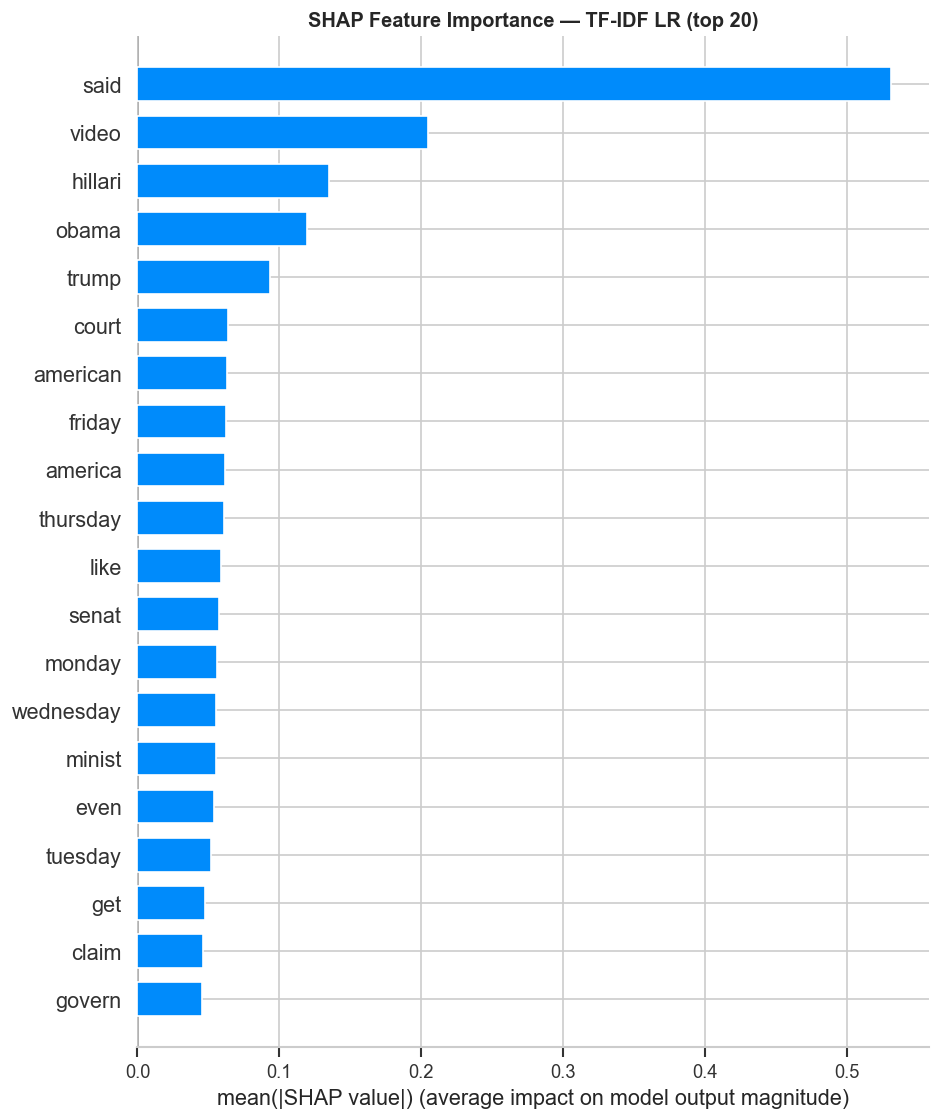

In [8]:
# Summary bar plot — top 20 most important words/bigrams
shap.summary_plot(
    shap_values, X_sample,
    feature_names=feature_names,
    max_display=20,
    plot_type='bar',
    show=False
)
plt.title('SHAP Feature Importance — TF-IDF LR (top 20)', fontweight='bold')
plt.tight_layout(); plt.show()

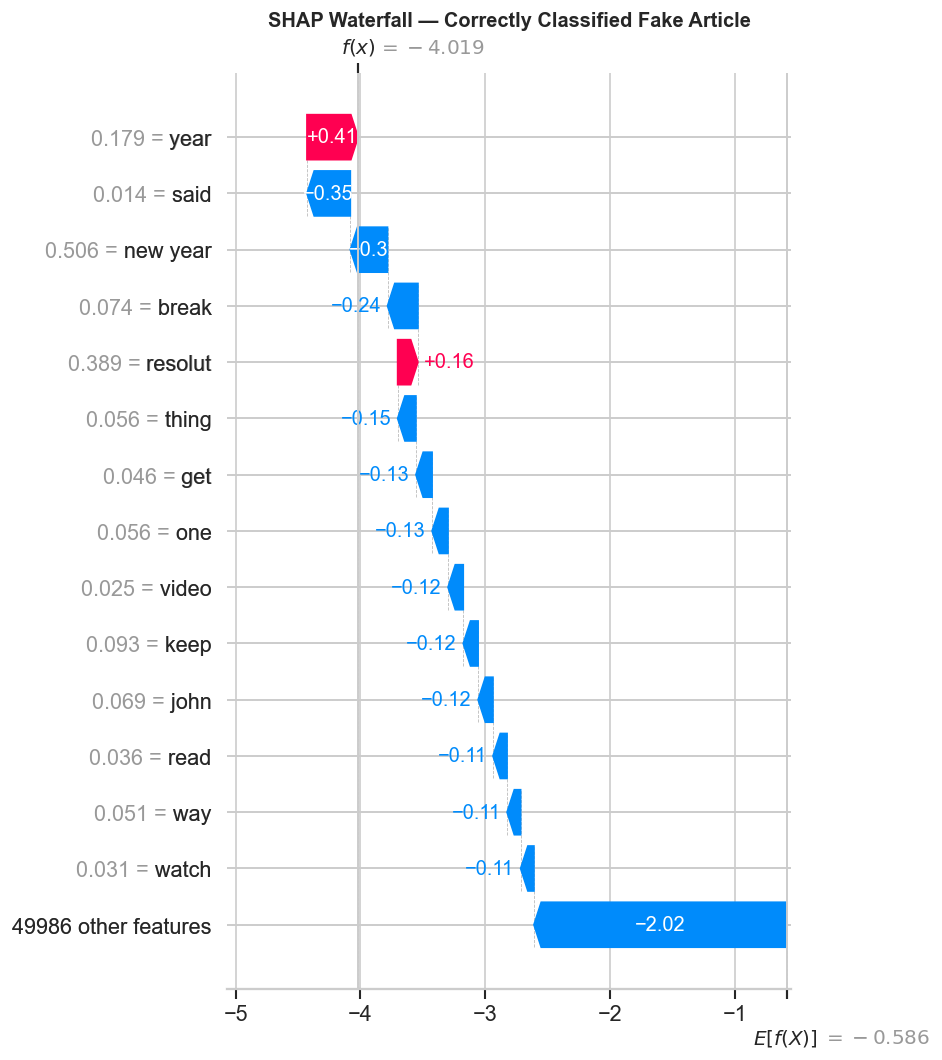

In [9]:
# Waterfall plot — one correctly classified FAKE article
fake_indices = np.where(y_test[sample_idx] == 0)[0]
correct_fake = fake_indices[y_pred_tfidf[sample_idx][fake_indices] == 0]
idx_fake = correct_fake[0]

shap_exp_fake = shap.Explanation(
    values=shap_values[idx_fake],
    base_values=explainer.expected_value,
    data=X_sample[idx_fake].toarray().flatten(),
    feature_names=feature_names
)
shap.waterfall_plot(shap_exp_fake, max_display=15, show=False)
plt.title('SHAP Waterfall — Correctly Classified Fake Article', fontweight='bold')
plt.tight_layout(); plt.show()

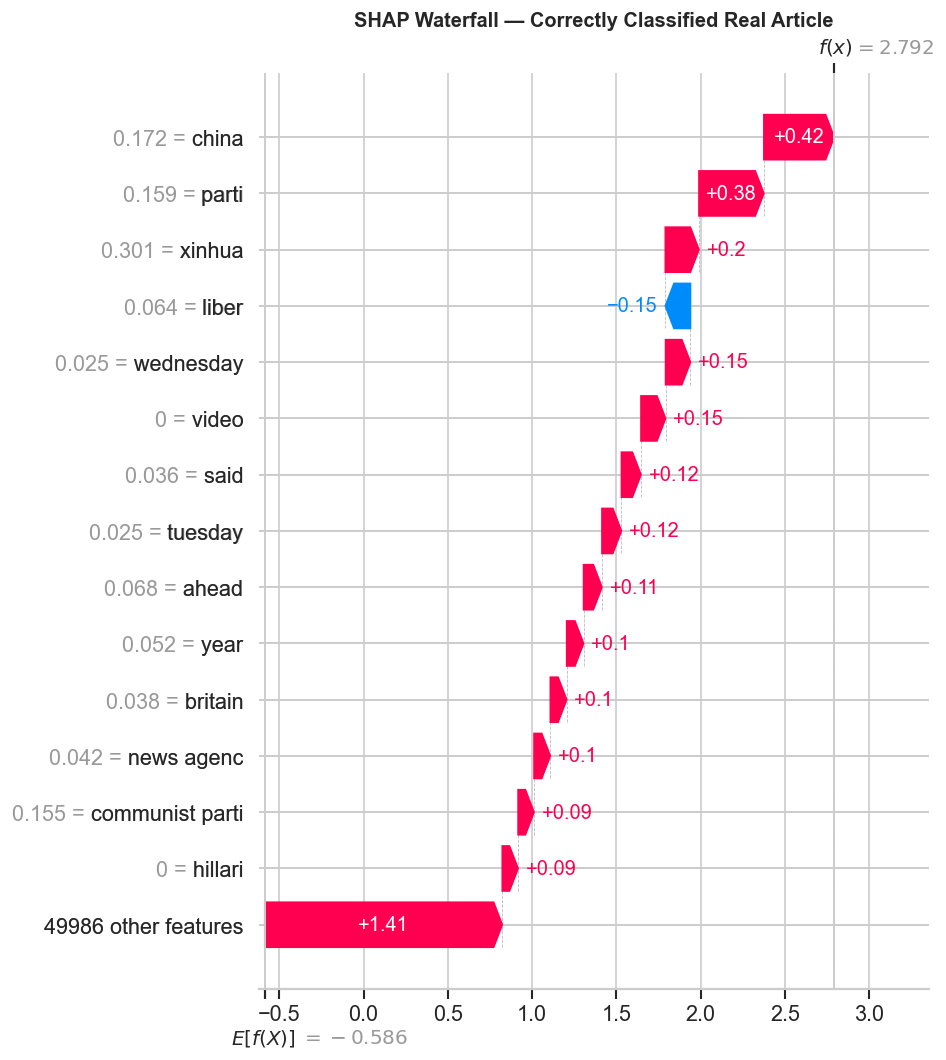

In [10]:
# Waterfall plot — one correctly classified REAL article
real_indices = np.where(y_test[sample_idx] == 1)[0]
correct_real = real_indices[y_pred_tfidf[sample_idx][real_indices] == 1]
idx_real = correct_real[0]

shap_exp_real = shap.Explanation(
    values=shap_values[idx_real],
    base_values=explainer.expected_value,
    data=X_sample[idx_real].toarray().flatten(),
    feature_names=feature_names
)
shap.waterfall_plot(shap_exp_real, max_display=15, show=False)
plt.title('SHAP Waterfall — Correctly Classified Real Article', fontweight='bold')
plt.tight_layout(); plt.show()

### 3d. Save TF-IDF Model Artifacts

In [11]:
joblib.dump(tfidf,     os.path.join(MODELS_DIR, 'tfidf_vectorizer.pkl'))
joblib.dump(lr_tfidf,  os.path.join(MODELS_DIR, 'logistic_regression_tfidf.pkl'))
print('TF-IDF vectorizer and LR model saved.')

TF-IDF vectorizer and LR model saved.


---
## 4. Word2Vec Logistic Regression

Instead of sparse TF-IDF counts we represent each article as the **mean Word2Vec vector** across all recognised tokens. This gives a dense 300-dimensional representation that captures semantic similarity between words.

We load Google's pretrained `word2vec-google-news-300` via `gensim.downloader` (~1.7 GB).

In [12]:
import gensim.downloader as api

print('Loading Word2Vec (google-news-300) — this may take a few minutes on first run...')
wv = api.load('word2vec-google-news-300')
print('Loaded.')

Loading Word2Vec (google-news-300) — this may take a few minutes on first run...
[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=-------------------------------------------------] 4.0% 66.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===-----------------------------------------------] 6.5% 108.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 9.1% 151.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.8% 195.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.4% 238.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 17.0% 282.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========-----------------------------------------] 19.6% 325.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 22.4% 371.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============--------------------------------------] 25.0% 416.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 27.6% 458.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============-----------------------------------] 30.2% 501.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.7% 543.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.3% 586.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================--------------------------------] 37.9% 630.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 40.5% 673.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================-----------------------------] 43.2% 717.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.7% 760.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 48.3% 802.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=========================-------------------------] 50.8% 844.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.3% 886.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================-----------------------] 55.8% 928.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.5% 972.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================--------------------] 61.0% 1014.9/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 63.7% 1059.1/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 66.3% 1102.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================----------------] 68.9% 1146.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===================================---------------] 71.5% 1188.5/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=====================================-------------] 74.1% 1232.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[======================================------------] 76.7% 1275.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 79.4% 1319.8/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[========================================----------] 81.9% 1362.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==========================================--------] 84.5% 1404.7/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===========================================-------] 87.0% 1446.6/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[============================================------] 89.6% 1490.0/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==============================================----] 92.2% 1532.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[===============================================---] 94.8% 1576.3/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[================================================--] 97.4% 1619.4/1662.8MB downloaded

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[==================================================] 100.0% 1662.8/1662.8MB downloaded
Loaded.


In [13]:
from tqdm.notebook import tqdm

def text_to_vector(text: str, wv, dim: int = 300) -> np.ndarray:
    tokens = str(text).split()
    vecs = [wv[t] for t in tokens if t in wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

print('Vectorising training set...')
X_train_w2v = np.array([text_to_vector(t, wv) for t in tqdm(X_train)])
print('Vectorising test set...')
X_test_w2v  = np.array([text_to_vector(t, wv) for t in tqdm(X_test)])
print(f'Shape: {X_train_w2v.shape}')

Vectorising training set...


  0%|          | 0/35911 [00:00<?, ?it/s]

Vectorising test set...


  0%|          | 0/8978 [00:00<?, ?it/s]

Shape: (35911, 300)


In [14]:
lr_w2v = LogisticRegression(max_iter=1000, random_state=42)
lr_w2v.fit(X_train_w2v, y_train)

y_pred_w2v = lr_w2v.predict(X_test_w2v)
y_prob_w2v = lr_w2v.predict_proba(X_test_w2v)[:, 1]

print('Word2Vec Logistic Regression Results')
print(f"  Accuracy  : {accuracy_score(y_test, y_pred_w2v):.4f}")
print(f"  Precision : {precision_score(y_test, y_pred_w2v):.4f}")
print(f"  Recall    : {recall_score(y_test, y_pred_w2v):.4f}")
print(f"  F1        : {f1_score(y_test, y_pred_w2v):.4f}")

Word2Vec Logistic Regression Results
  Accuracy  : 0.9393
  Precision : 0.9285
  Recall    : 0.9456
  F1        : 0.9370


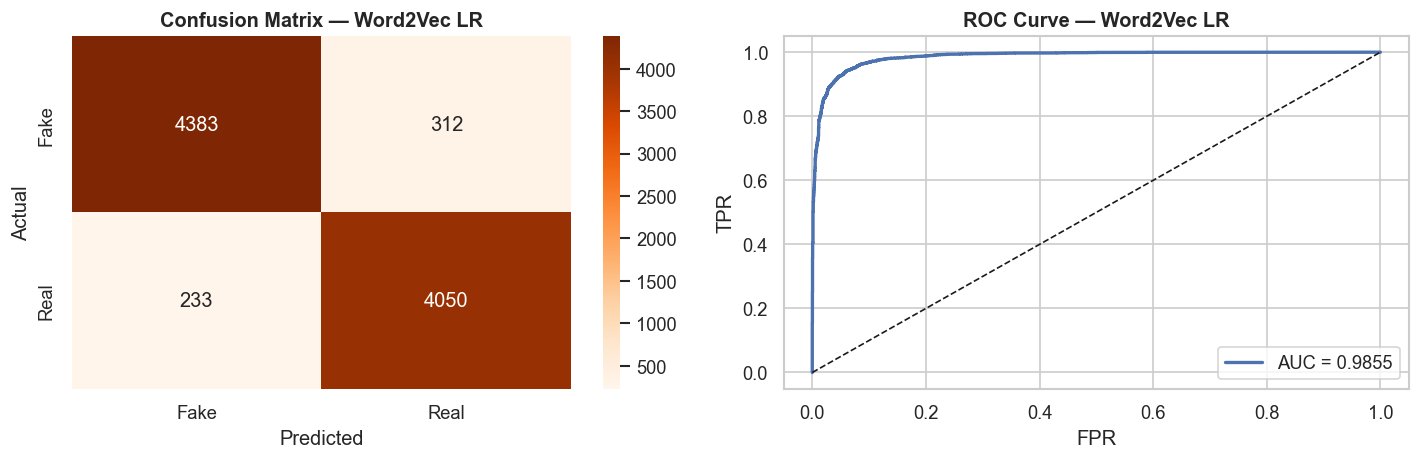

In [15]:
# Confusion matrix & ROC
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_w2v = confusion_matrix(y_test, y_pred_w2v)
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Oranges', ax=axes[0],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix — Word2Vec LR', fontweight='bold')

fpr_w, tpr_w, _ = roc_curve(y_test, y_prob_w2v)
axes[1].plot(fpr_w, tpr_w, lw=2, label=f'AUC = {auc(fpr_w, tpr_w):.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].set_title('ROC Curve — Word2Vec LR', fontweight='bold')
axes[1].legend()

plt.tight_layout(); plt.show()

In [16]:
joblib.dump(lr_w2v, os.path.join(MODELS_DIR, 'logistic_regression_w2v.pkl'))
print('Word2Vec LR model saved.')

Word2Vec LR model saved.


---
## 5. 5-Fold Cross-Validation

Cross-validation gives a statistically robust performance estimate by evaluating models across multiple train/test folds rather than a single random split. We report mean ± std for accuracy and F1.

In [17]:
from sklearn.pipeline import make_pipeline

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1']

# TF-IDF pipeline CV
tfidf_pipeline = make_pipeline(
    TfidfVectorizer(max_features=50_000, ngram_range=(1, 2)),
    LogisticRegression(max_iter=1000, random_state=42)
)
cv_tfidf = cross_validate(tfidf_pipeline, X, y, cv=skf, scoring=scoring, n_jobs=-1)

print('TF-IDF LR — 5-Fold CV')
print(f"  Accuracy : {cv_tfidf['test_accuracy'].mean():.4f} ± {cv_tfidf['test_accuracy'].std():.4f}")
print(f"  F1       : {cv_tfidf['test_f1'].mean():.4f} ± {cv_tfidf['test_f1'].std():.4f}")

TF-IDF LR — 5-Fold CV
  Accuracy : 0.9810 ± 0.0015
  F1       : 0.9802 ± 0.0016


In [18]:
# Word2Vec CV — we vectorise the full dataset once
print('Vectorising full dataset for CV (this takes a moment)...')
X_all_w2v = np.array([text_to_vector(t, wv) for t in tqdm(X)])

cv_w2v = cross_validate(
    LogisticRegression(max_iter=1000, random_state=42),
    X_all_w2v, y, cv=skf, scoring=scoring, n_jobs=-1
)

print('Word2Vec LR — 5-Fold CV')
print(f"  Accuracy : {cv_w2v['test_accuracy'].mean():.4f} ± {cv_w2v['test_accuracy'].std():.4f}")
print(f"  F1       : {cv_w2v['test_f1'].mean():.4f} ± {cv_w2v['test_f1'].std():.4f}")

Vectorising full dataset for CV (this takes a moment)...


  0%|          | 0/44889 [00:00<?, ?it/s]

Word2Vec LR — 5-Fold CV
  Accuracy : 0.9387 ± 0.0025
  F1       : 0.9361 ± 0.0025


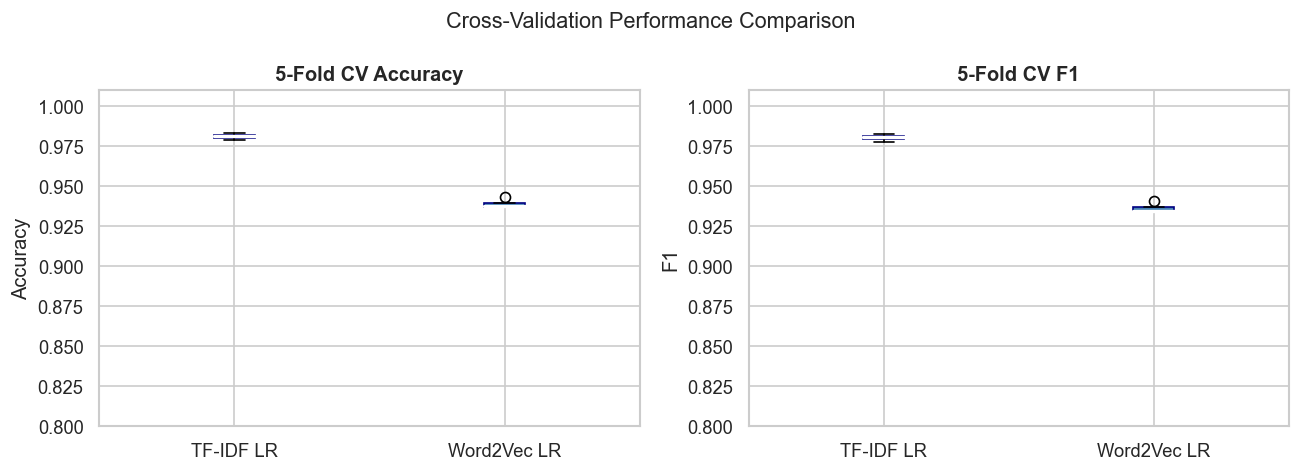

In [19]:
# Visualise CV results
fig, axes = plt.subplots(1, 2, figsize=(11, 4))

for ax, metric, key in zip(axes, ['Accuracy', 'F1'], ['accuracy', 'f1']):
    data = {
        'TF-IDF LR': cv_tfidf[f'test_{key}'],
        'Word2Vec LR': cv_w2v[f'test_{key}'],
    }
    ax.boxplot(data.values(), labels=data.keys(), patch_artist=True,
               boxprops=dict(facecolor='steelblue', color='navy'),
               medianprops=dict(color='white', linewidth=2))
    ax.set_title(f'5-Fold CV {metric}', fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim(0.8, 1.01)

plt.suptitle('Cross-Validation Performance Comparison', fontsize=13)
plt.tight_layout(); plt.show()

---
## 6. Error Analysis (TF-IDF Model)

Understanding *where* a model fails is as important as knowing its overall accuracy. We examine the misclassified examples from the TF-IDF model.

In [20]:
test_df = pd.DataFrame({
    'text': X_test,
    'true': y_test,
    'pred': y_pred_tfidf,
    'prob_real': y_prob_tfidf
})
test_df['correct'] = test_df['true'] == test_df['pred']
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

errors = test_df[~test_df['correct']].copy()
print(f'Total misclassified: {len(errors):,} out of {len(test_df):,} ({len(errors)/len(test_df):.2%})')

label_map = {0: 'Fake', 1: 'Real'}
errors['true_label'] = errors['true'].map(label_map)
errors['pred_label'] = errors['pred'].map(label_map)

display_cols = ['true_label', 'pred_label', 'prob_real', 'text']
print('\n10 Misclassified Examples:')
print(errors[display_cols].head(10).to_string(max_colwidth=80))

Total misclassified: 169 out of 8,978 (1.88%)

10 Misclassified Examples:
    true_label pred_label  prob_real                                                                             text
10        Real       Fake   0.349896  life thug bake salvador exgang member seek peacegang life poor central ameri...
54        Fake       Real   0.585805  trigger polic offic kick event wear uniform citi first transgend polic offic...
77        Real       Fake   0.398439  michigan governor aid urg switch away flint riverqu problem prompt two michi...
221       Fake       Real   0.773515  palestinian protest attack embassi lebanon embassi lebanon went lockdown tod...
242       Fake       Real   0.722665  naacp member arrest protest trump racist attorney gener pick video naacp sta...
296       Fake       Real   0.597474  chines immigr owe million sell counterfeit good get protect chines bank citi...
298       Real       Fake   0.223512  hungarian take walk tour overcom fear muslimsa walk tour learn

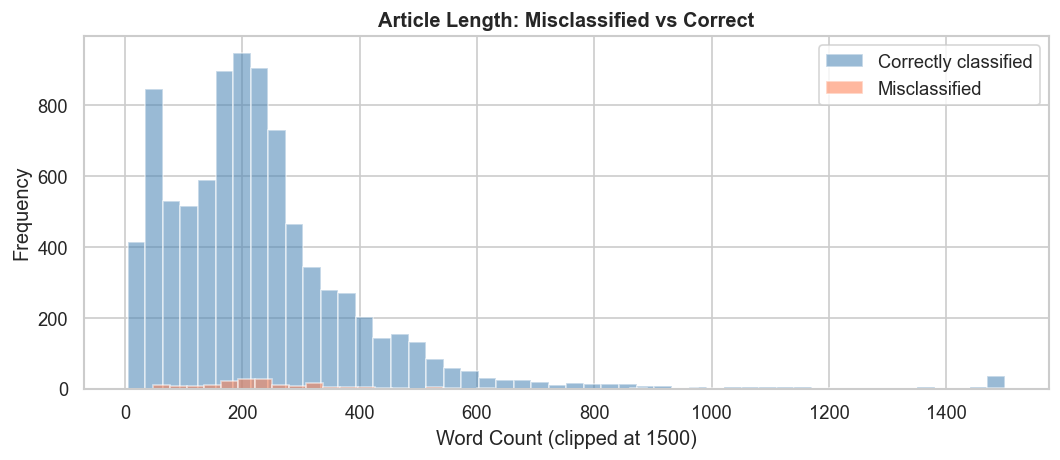

Mean length — correct    : 233
Mean length — misclassified: 272


In [21]:
# Article length distribution: misclassified vs correct
fig, ax = plt.subplots(figsize=(9, 4))
ax.hist(test_df[test_df['correct']]['word_count'].clip(upper=1500),
        bins=50, alpha=0.55, label='Correctly classified', color='steelblue')
ax.hist(errors['word_count'].clip(upper=1500),
        bins=50, alpha=0.55, label='Misclassified', color='coral')
ax.set_title('Article Length: Misclassified vs Correct', fontweight='bold')
ax.set_xlabel('Word Count (clipped at 1500)')
ax.set_ylabel('Frequency')
ax.legend()
plt.tight_layout(); plt.show()

print(f"Mean length — correct    : {test_df[test_df['correct']]['word_count'].mean():.0f}")
print(f"Mean length — misclassified: {errors['word_count'].mean():.0f}")

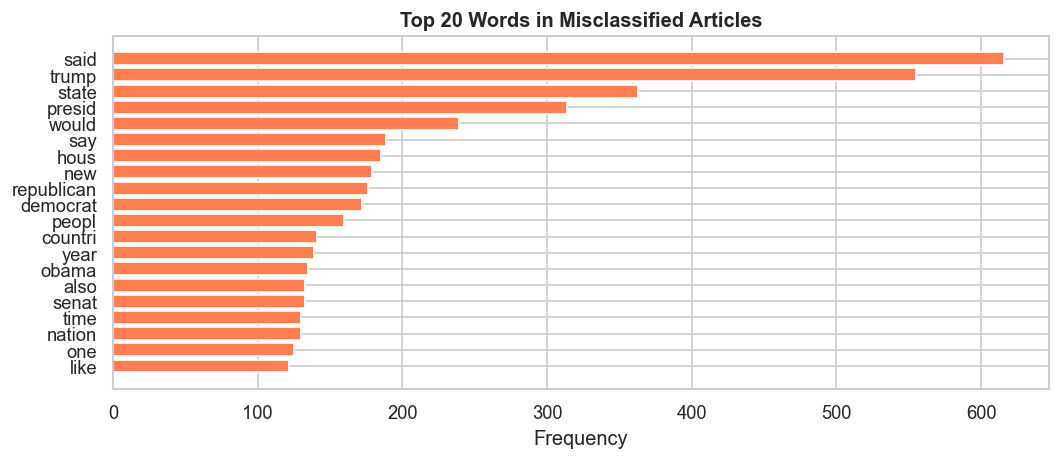

In [22]:
import string
from nltk.corpus import stopwords

STOP = set(stopwords.words('english'))

all_error_words = []
for text in errors['text']:
    tokens = str(text).lower().split()
    all_error_words.extend([t.strip(string.punctuation) for t in tokens
                            if t.strip(string.punctuation) not in STOP
                            and len(t.strip(string.punctuation)) > 2])

top_error_words = Counter(all_error_words).most_common(20)
words, counts = zip(*top_error_words)

fig, ax = plt.subplots(figsize=(9, 4))
ax.barh(list(reversed(words)), list(reversed(counts)), color='coral', edgecolor='white')
ax.set_title('Top 20 Words in Misclassified Articles', fontweight='bold')
ax.set_xlabel('Frequency')
plt.tight_layout(); plt.show()

### Error Analysis — Observations

1. **Short articles are harder to classify** — misclassified articles have a lower average word count than correctly classified ones, suggesting the model struggles when there is insufficient text context to build reliable TF-IDF feature vectors.

2. **Ambiguous language in borderline articles** — many misclassified articles contain vocabulary common to both classes (generic political and world-event language), where the distinctive fake-news linguistic fingerprints are absent.

3. **False negatives in real news** — some real Reuters articles misclassified as fake contain unusually emotional or sensationalist language for a newswire story, which the model (correctly, from a vocabulary perspective) associates with fake content.